# Image Classification using AWS SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug --quiet
!pip install datasets --quiet
!pip install pip --upgrade --quiet
!pip install ipywidgets --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
ERROR: pip's dependency resolver does not currently take into account all the packag

In [3]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [4]:
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = session.default_bucket()
bucket

'sagemaker-us-east-1-328945632120'

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [7]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-03-23 22:53:56--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.64
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  44.5MB/s    in 33s     

2022-03-23 22:54:31 (32.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

**Note**: It's important you either delete this file in the **train** dataset or pass it into an error handler: Leonberger_06571.jpg. It might be quite large and it causes issues. 

In [9]:
# Let's explore our files | Source @Skysign: https://bit.ly/3CZRzg5
import numpy as np
from glob import glob
dog_files = np.array(glob("dogImages/*/*/*"))
training_dog_files = np.array(glob("dogImages/train/*/*"))
test_dog_files = np.array(glob("dogImages/test/*/*"))
validation_dog_files = np.array(glob("dogImages/valid/*/*"))

print('There are %d total dog images.' % len(dog_files))
print('There are %d total dog images in training set.' % len(training_dog_files))
print('There are %d total dog images in test set.' % len(test_dog_files))
print('There are %d total dog images in validation set.' % len(validation_dog_files))

There are 8350 total dog images.
There are 6679 total dog images in training set.
There are 836 total dog images in test set.
There are 835 total dog images in validation set.


In [16]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/dogImages/train/
!aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/dogImages/test/
!aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/dogImages/valid/

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [17]:
# CONSIDER: passing in some categoricalparams for epoch sizes also AND pass the best epoch into debugger and profiler steps
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "momentum": ContinuousParameter(0.001, 1),
    "train-batch-size": CategoricalParameter([5, 10]),
}

In [18]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [23]:
#TODO: Create estimators for your HPs

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    base_job_name="predict-dogImages",
    instance_type="ml.c5.2xlarge" # "ml.m5.large" | ml.p3.2xlarge (very expensive) | ml.c5.2xlarge	
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=1, #change as needed
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [24]:
# TODO: Fit your HP Tuner
tuner.fit() # TODO: Remember to include your data channels

..................................................................................................................................................................................................................................................................................................!


In [26]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-03-24 00:16:57 Starting - Preparing the instances for training
2022-03-24 00:16:57 Downloading - Downloading input data
2022-03-24 00:16:57 Training - Training image download completed. Training in progress.
2022-03-24 00:16:57 Uploading - Uploading generated training model
2022-03-24 00:16:57 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'lr': '0.002410630846820163',
 'momentum': '0.2987746316324333',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"predict-dogImages-2022-03-23-23-53-25-503"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-328945632120/predict-dogImages-2022-03-23-23-53-25-503/source/sourcedir.tar.gz"',
 'train-batch-size': '"5"'}

In [6]:
# let's pass our hyperparams programmatically into the profiling and debugging steps
# hyper_params = best_estimator.hyperparameters()
hyper_params

{'_tuning_objective_metric': '"average test loss"',
 'lr': '0.002410630846820163',
 'momentum': '0.2987746316324333',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"predict-dogImages-2022-03-23-23-53-25-503"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-328945632120/predict-dogImages-2022-03-23-23-53-25-503/source/sourcedir.tar.gz"',
 'train-batch-size': '"5"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [5]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [36]:
# Let's pass in our hyper_params
# Change epoch size as needed
# Note batch size is string likely because it's passed in as categorical parameter
hyperparameters = {"epochs": "1", "train-batch-size": hyper_params['train-batch-size'].replace('"',""), "momentum": hyper_params["momentum"], "lr": hyper_params["lr"]}
hyperparameters


{'epochs': '1',
 'train-batch-size': '5',
 'momentum': '0.2987746316324333',
 'lr': '0.002410630846820163'}

In [41]:
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m4.xlarge", # ml.p3.2xlarge
#     source_dir="scripts",
    entry_point="train_model.py", 
    framework_version="1.8",
    py_version="py36",
    base_job_name="predict-dogImages-debug",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)


In [42]:
estimator.fit(wait=True)

2022-03-24 06:00:02 Starting - Starting the training job...LossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2022-03-24 06:00:56 Starting - Preparing the instances for training.........
2022-03-24 06:02:22 Downloading - Downloading input data...
2022-03-24 06:03:02 Training - Downloading the training image......
2022-03-24 06:04:02 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-24 06:04:01,613 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-24 06:04:01,616 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-03-24 06:04:01,636 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed

In [45]:
boto_session_obj = boto3.session.Session()
region = boto_session_obj.region_name
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: predict-dogImages-debug-2022-03-24-06-00-01-578
Region: us-east-1


In [46]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-03-24 06:46:06.630 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-24 06:46:06.649 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-328945632120/predict-dogImages-debug-2022-03-24-06-00-01-578/debug-output


In [47]:
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2022-03-24 06:46:33.449 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-03-24 06:46:34.470 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'CrossEntropyLoss_output_1', 'gradient/SqueezeNet_classifier.1.bias', 'gradient/SqueezeNet_classifier.1.weight']
6
1


In [55]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [56]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


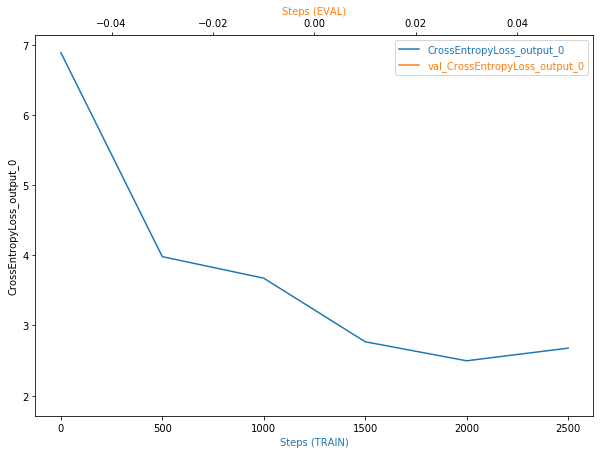

In [58]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [48]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-328945632120/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-328945632120/predict-dogImages-debug-2022-03-24-06-00-01-578/profiler-output


Profiler data from system is available


In [51]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)


[2022-03-24 06:47:54.974 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO metrics_reader_base.py:134] Getting 37 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [52]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-328945632120/predict-dogImages-debug-2022-03-24-06-00-01-578/rule-output


In [53]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2022-03-24 06:38:21     387421 predict-dogImages-debug-2022-03-24-06-00-01-578/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-03-24 06:38:20     237473 predict-dogImages-debug-2022-03-24-06-00-01-578/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-03-24 06:38:15        192 predict-dogImages-debug-2022-03-24-06-00-01-578/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-03-24 06:38:15        200 predict-dogImages-debug-2022-03-24-06-00-01-578/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-03-24 06:38:15       2195 predict-dogImages-debug-2022-03-24-06-00-01-578/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-03-24 06:38:15        127 predict-dogImages-debug-2022-03-24-06-00-01-578/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-03-24 06:38:15        199 predict-dogImages-debug-2022-03-24-06-00-01-578/rule-

In [54]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Model Deploying

In [60]:
# TODO: Deploy your model to an endpoint

predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

--------!

In [63]:
print(predictor)

In [71]:
from PIL import Image

In [74]:
path = './dogImages/valid/012.Australian_shepherd/Australian_shepherd_00808.jpg'
image = Image.open(path).convert('RGB')

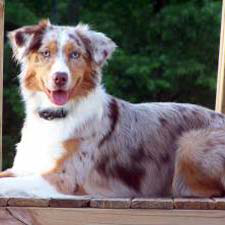

In [75]:
image

In [92]:
print(image.size)
print(image.mode)

(225, 225)
RGB


In [98]:
import numpy as np
from numpy import asarray
image_arr = asarray(image)
image_arr=np.reshape(image_arr, (224, 224))

# image_arr = np.moveaxis(image_arr, -1, 0) # moving channel axis to the beginning as our PyTorch model expects
# image_arr = np.expand_dims(image_arr, axis=0) # simulating a batch size of 1 per PyTorch expected input
image_arr.shape

ValueError: cannot reshape array of size 151875 into shape (224,224)

In [90]:
# TODO: Run a prediction on the endpoint

# image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image_arr)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/predict-dogImages-debug-2022-03-24-06-53-36-004 in account 328945632120 for more information.

In [ ]:
response

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()